In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial.distance import cdist

In [2]:
def read_spatial_expression(file,sep='\s+',
                            num_exp_genes=0.01, num_exp_spots=0.01, min_expression=1,
                            drop = False):
    
    '''
    Read raw data and returns pandas data frame of spatial gene express
    and numpy ndarray for single cell location coordinates; 
    Meanwhile processing raw data.
    
    :param file: csv file for spatial gene expression; 
    :rtype: coord (spatial coordinates) shape (n, 2); data: shape (n, m); 
    '''
    counts = pd.read_csv(file, sep=sep, index_col = 0)
    print('raw data dim: {}'.format(counts.shape))

    num_spots = len(counts.index)
    num_genes = len(counts.columns)
    min_genes_spot_exp = round((counts != 0).sum(axis=1).quantile(num_exp_genes))
    print("Number of expressed genes a spot must have to be kept " \
    "({}% of total expressed genes) {}".format(num_exp_genes, min_genes_spot_exp))
    
    mark_points = np.where((counts != 0).sum(axis=1) < min_genes_spot_exp)[0]
    print("Marked {} spots".format(len(mark_points)))
    
    if len(mark_points)>0:
        noiseInd = [counts.shape[0]-1-i for i in range(len(mark_points))]
        if drop == False:
            temp = [val.split('x') for val in counts.index.values]
            coord = np.array([[float(a[0]), float(a[1])] for a in temp])

            similar_points=np.argsort(cdist(coord[mark_points,:],coord),axis=1)[:,1]
            for i,j in zip(mark_points,similar_points):
                counts.iloc[i,:]=counts.iloc[j,:]
        
            mark_counts=counts.iloc[mark_points,:]
            dropped_counts = counts.drop(counts.index[mark_points])
            counts=pd.concat([dropped_counts,mark_counts])  
            
        else:    
            counts = counts[(counts != 0).sum(axis=1) >= min_genes_spot_exp]
    else:
        counts = counts
        noiseInd =[] 
    
    # Spots are columns and genes are rows
    counts = counts.transpose()
    # Remove noisy genes
    min_features_gene = round(len(counts.columns) * num_exp_spots) 
    print("Removing genes that are expressed in less than {} " \
    "spots with a count of at least {}".format(min_features_gene, min_expression))
    counts = counts[(counts >= min_expression).sum(axis=1) >= min_features_gene]
    print("Dropped {} genes".format(num_genes - len(counts.index)))
    
    temp = [val.split('x') for val in counts.columns.values]
    coord = np.array([[float(a[0]), float(a[1])] for a in temp])

    data=counts.transpose()

    return coord,data, noiseInd

In [40]:
data_dir = '../dataset/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv'
locs,data,_=read_spatial_expression(data_dir)
locs_df = pd.DataFrame(locs,columns=['imagerow', 'imagecol'])
locs_df.index = data.index
adata = sc.AnnData(X=data,
                        obs=locs_df)

raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


In [4]:
adata

AnnData object with n_obs × n_vars = 262 × 14659
    obs: 'imagerow', 'imagecol'

In [5]:
target_gene = 'Sparcl1'

In [6]:
exp = adata[:,target_gene].X.toarray()

In [7]:
from sklearn.mixture import GaussianMixture

In [8]:
gmm = GaussianMixture(n_components=2)
gmm.fit(exp)
labels = gmm.predict(exp)

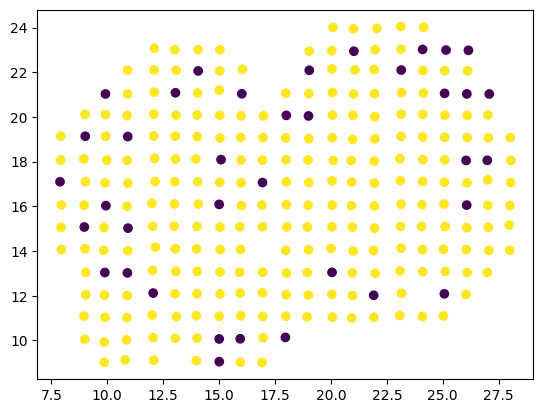

In [9]:
from matplotlib import pyplot as plt
plt.scatter(locs[:,0],locs[:,1],c=labels)


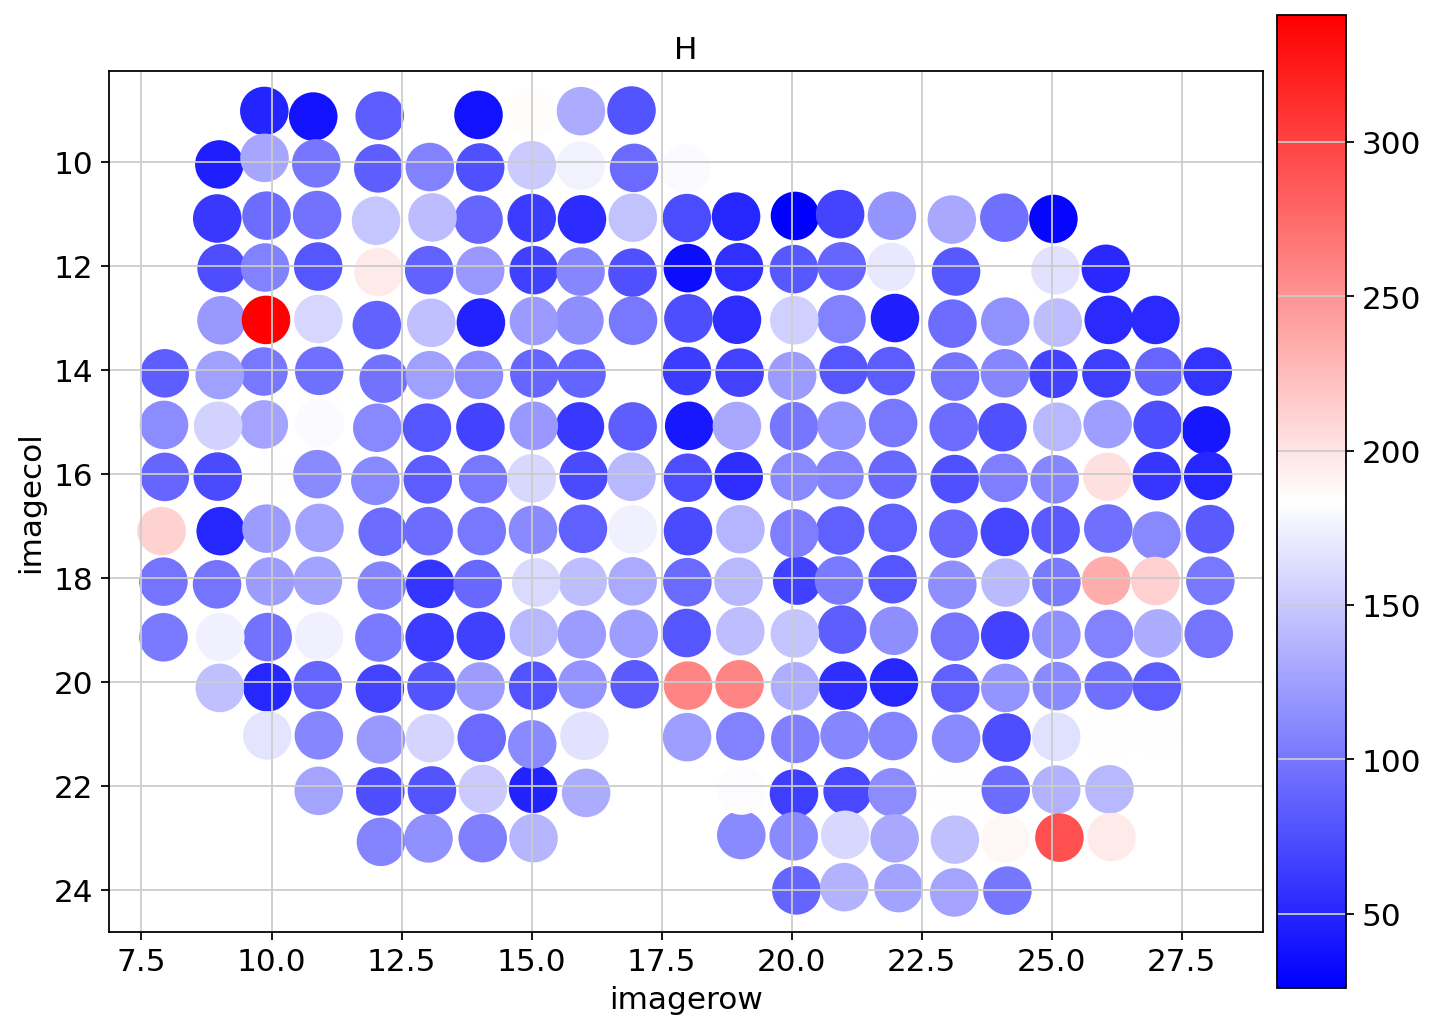

In [10]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata,alpha=1,x="imagerow",y="imagecol", color = target_gene,
                 title='H',show=False,size=500000/adata.shape[0],
                color_map='bwr')
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()

In [11]:
from src import * 

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from scipy import sparse as sp

In [54]:
def get_binary_weight(adata, n_neighbors = 4):
    coor = adata.obs
    coor = coor.loc[:,['imagerow', 'imagecol']]
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    nbrs = NearestNeighbors(n_neighbors= n_neighbors).fit(coor)
    distances, indices = nbrs.kneighbors(coor, return_distance=True)
    KNN_list = []
    for it in range(indices.shape[0]):
        KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']
    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    
    #out = pd.get_dummies(Spatial_Net.set_index("Cell1")['Cell2'],sparse=True).max(level=0)
    G_df = Spatial_Net
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)
    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])
        
    return G

In [43]:
def get_binary_weight(adata,
                     rad_cutoff):
    
    coor = adata.obs
    coor = coor.loc[:,['imagerow', 'imagecol']]
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    nbrs = NearestNeighbors(radius=rad_cutoff).fit(coor)
    distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
    KNN_list = []
    for it in range(indices.shape[0]):
        KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']
    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    
    #out = pd.get_dummies(Spatial_Net.set_index("Cell1")['Cell2'],sparse=True).max(level=0)
    G_df = Spatial_Net
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)
    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])
        
    return G

In [55]:
cellGraph = get_binary_weight(adata)

In [56]:
cellGraph.count_nonzero()

1048

In [47]:
cellGraph.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [41]:
adata

AnnData object with n_obs × n_vars = 262 × 14659
    obs: 'imagerow', 'imagecol'

In [ ]:
locs =
nbrs = NearestNeighbors(n_neighbors=4).fit(locs)